#### This methoth uses MCMC for PC1 and 2

In [103]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.distributions as dist
import pyro.optim as optim

In [104]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.3') #Changed from 1.8.4
pyro.set_rng_seed(1)

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
import warnings
warnings.filterwarnings('ignore')

In [105]:
# Added
from typing import Callable, Optional

In [106]:
import subprocess

In [107]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [108]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible,
)
from pyro.infer.reparam import AutoReparam, LocScaleReparam
from pyro.nn.module import PyroParam
from pyro.optim import ClippedAdam
from pyro.ops.special import sparse_multinomial_likelihood
import matplotlib.pyplot as plt


In [109]:
from platform import python_version
print(python_version())
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

3.9.15
tensor([1.], device='mps:0')


In [110]:
os.chdir("/Users/....")

In [111]:
Flyer2018_16S_table_counts = pd.read_csv('Flyer2018_16S_table_counts.tsv', sep='\t')
Flyer2018_16S_table_counts.head(3)

,ASV ID,CN18Fc12_8_eDNA,CN18Fc19_5_eDNA,CN18Fc21_6_eDNA,CN18Fc22_6_eDNA,CN18Fc24_6_eDNA,CN18Fc25_5_eDNA,CN18Fc27_4_eDNA,CN18Fc29_6_eDNA,CN18Fc30_4_eDNA,...,CN18SESPkoa_SC36,CN18SESPkoa_SC37,CN18SESPkoa_SC39,CN18SESPkoa_SC40,CN18SESPkoa_SC41,CN18SESPkoa_SC42,CN18SESPkoa_SC44,CN18SESPkoa_SC45,CN18SESPkoa_SC47,CN18SESPkoa_SC49
0,495c1bd1608a1dad54d3e2824ce899ef,552,7415,8749,8152,7124,12422,215,8080,8799,...,4324,1339,95,1554,147,2720,21,2015,1847,1886
1,a900b6678ce86851fb16bfafb87f3326,210,1933,2808,1967,1671,4912,57,3688,3343,...,21023,8898,1367,8291,1112,9881,60,8726,9330,8852
2,c8e360969108fa2125a3d56eb4dad24f,145,2089,2530,2086,2343,2395,129,1625,1664,...,4830,9,566,20,551,60,43,22,28,44


In [112]:
Flyer2018_18S_table_counts = pd.read_csv('Flyer2018_18S_table_counts.tsv', sep='\t')
Flyer2018_18S_table_counts.head(3)

,ASV ID,CN18Fc12_8_eDNA,CN18Fc19_5_eDNA,CN18Fc21_6_eDNA,CN18Fc22_6_eDNA,CN18Fc24_6_eDNA,CN18Fc25_5_eDNA,CN18Fc27_4_eDNA,CN18Fc29_6_eDNA,CN18Fc30_4_eDNA,...,CN18SESPkoa_SC36,CN18SESPkoa_SC37,CN18SESPkoa_SC39,CN18SESPkoa_SC40,CN18SESPkoa_SC41,CN18SESPkoa_SC42,CN18SESPkoa_SC44,CN18SESPkoa_SC45,CN18SESPkoa_SC47,CN18SESPkoa_SC49
0,ASV_1,1,0,3,0,0,3,0,1,7,...,7,2,3,2,1,2,1,2,5,4
1,ASV_2,0,0,0,0,0,0,0,0,1,...,2,0,0,0,2,1,2,1,1,1
2,ASV_3,2,0,23,6,5,0,0,3,1,...,1,86,2,51,2,94,2,12,24,13


## 02. Reduce dimensionality and visualize principal components

In [113]:
from sklearn.decomposition import PCA
import seaborn as sns

In [114]:
# Untransformed
df_16S = pd.read_csv("Flyer2018_16S_counts_modeled.tsv", index_col=0, sep='\t')
df_16S.head(3) 

,495c1bd1608a1dad54d3e2824ce899ef,a900b6678ce86851fb16bfafb87f3326,c8e360969108fa2125a3d56eb4dad24f,72143fd9e63fe40c1258948d2f0d79c3,7b6b178fad5599c0e9a734e4fb09fd64,4bbec3bb723375416616a87d785ac74a,0c35cfa523aa27921ef8544a16d1cd36,7ec69f2c62aad60e060e588ef687bdd0,61e9a50f4346bb3a5b16179b8eca71fa,a140195871278e8fcf9447e42bad8786,...,995cc65bcfa53a868c42615004e99ad3,46b90aab075ecd8e4db549da708550d8,c4e1933274329209b7cf24daf18dfe0d,aa9e141a5e2781d280406c513bf34d45,d7682f536589fc5f920533513dd0002b,674933a0d44342a0647f7a5b4591f26e,bebe1b9a7e9aaa78172c1208111f4570,0128431733f67d02efad766d717fe6fd,41102a7dd1f4647ba5477c947daabc0e,51440f89c391fb32f9ee895db22bf8f8
CN18Fc12_8_eDNA,0.078575,0.026310,0.020724,0.021095,0.022934,0.006699,0.000157,0.013179,0.027785,0.014921,...,2.675397e-04,0.000308,0.000390,1.813856e-04,0.000234,0.000076,0.000006,0.000094,0.000236,0.000318
CN18Fc19_5_eDNA,0.168358,0.043740,0.048614,0.042913,0.039488,0.011911,0.005591,0.013227,0.016948,0.021451,...,5.762832e-07,0.000031,0.000023,6.721208e-07,0.000029,0.000002,0.000017,0.000006,0.000010,0.000024
CN18Fc21_6_eDNA,0.134430,0.043606,0.037413,0.038204,0.026781,0.011280,0.010190,0.017474,0.023713,0.019526,...,3.480240e-05,0.000006,0.000010,8.968874e-06,0.000014,0.000036,0.000047,0.000002,0.000005,0.000050


In [115]:
# Untransformed
df_18S =  pd.read_csv('Flyer2018_18S_counts_modeled.tsv', index_col=0, sep='\t')
df_18S.head(3) 

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_12597,ASV_12598,ASV_12599,ASV_12600,ASV_12605,ASV_12614,ASV_12622,ASV_12628,ASV_12632,ASV_12654
CN18Fc12_8_eDNA,0.000005,0.000029,0.000119,0.000197,0.000377,0.004449,0.013663,0.073634,0.000027,0.001633,...,0.000007,0.000069,0.000014,4.027541e-05,0.000064,0.000006,0.000004,3.411997e-06,0.000009,0.000053
CN18Fc19_5_eDNA,0.000018,0.000004,0.000046,0.227985,0.000190,0.003012,0.004586,0.029073,0.000019,0.000089,...,0.000048,0.000012,0.000002,1.089982e-05,0.000038,0.000007,0.000002,3.157258e-07,0.000023,0.000055
CN18Fc21_6_eDNA,0.000090,0.000007,0.000393,0.000053,0.000373,0.004220,0.007627,0.052156,0.000020,0.000142,...,0.000009,0.000020,0.000010,7.565762e-07,0.000002,0.000003,0.000039,3.912594e-06,0.000008,0.000027


In [116]:
# Untransformed 16S
pca = PCA(n_components=62)
pca.fit_transform(df_16S)
variance_array_16S = np.cumsum(pca.explained_variance_ratio_ * 100)
variance_array_16S[:6]

array([61.61338587, 90.67447154, 93.27625073, 95.41199962, 96.68587848,
       97.33998237])

In [117]:
# Untransformed 18S
pca = PCA(n_components=62)
pca.fit_transform(df_18S)
variance_array_18S = np.cumsum(pca.explained_variance_ratio_ * 100)
variance_array_18S[:10]

array([27.01916127, 44.47152057, 61.70139986, 69.53210245, 76.43468491,
       80.91389974, 84.92249819, 87.13748577, 89.13884596, 90.78166268])

### Plot components vs variance explained

#### Based on the results above we will use the variances generated from the raw (untransformed) count probabilities

### Function to format variance numpy array for seaborn plot

In [118]:
def format_variance_data_for_plotting(variance_array):
    df = pd.DataFrame(variance_array, columns = ["Explained variance"])
    df = df.reset_index(level=0)
    df['index'] = df['index'] + 1
    df = df.rename(columns = {"index" : "Component number"})
    return(df)

#### Apply function to raw count probabilities

[Text(0.5, 1.0, 'Principal components of ASV count probabilities')]

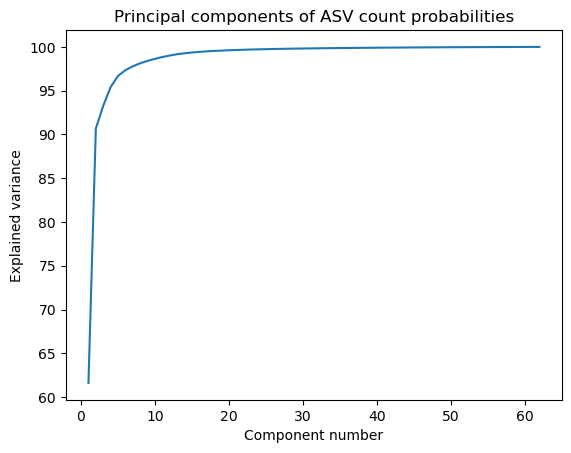

In [119]:
# 16S count data
df_variance = format_variance_data_for_plotting(variance_array_16S)
sns.lineplot(data=df_variance, x="Component number", 
             y="Explained variance").set(title='Principal components of ASV count probabilities')

[Text(0.5, 1.0, 'Principal components of ASV count probabilities')]

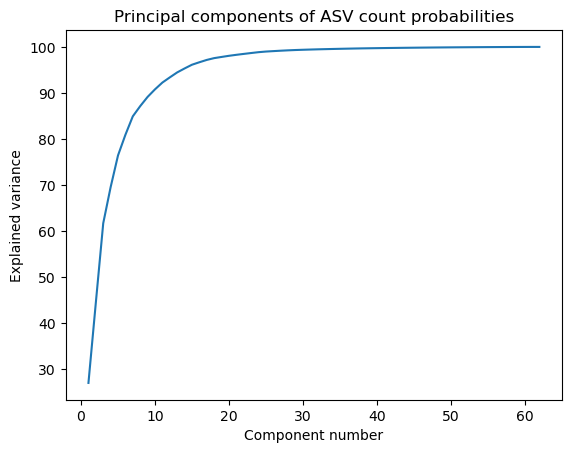

In [120]:
# 18S count data
df_variance = format_variance_data_for_plotting(variance_array_18S)
sns.lineplot(data=df_variance, x="Component number", 
             y="Explained variance").set(title='Principal components of ASV count probabilities') 

### Plot principal components of raw ASV count probabilities

[Text(0.5, 1.0, '16S PCA, raw count probabilities')]

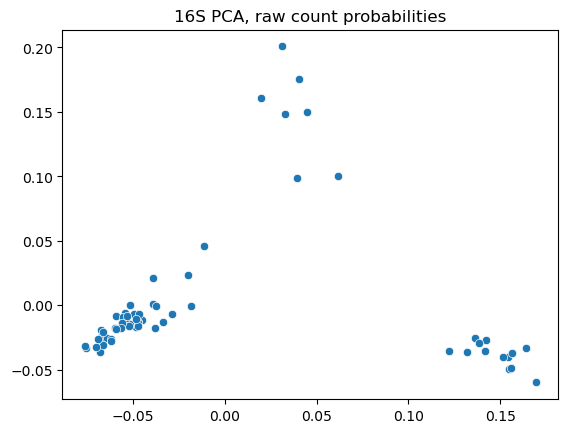

In [121]:
pca = PCA(n_components=3)
pcs = pca.fit_transform(df_16S)

pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values).set(title="16S PCA, raw count probabilities")

[Text(0.5, 1.0, '18S PCA, raw count probabilities')]

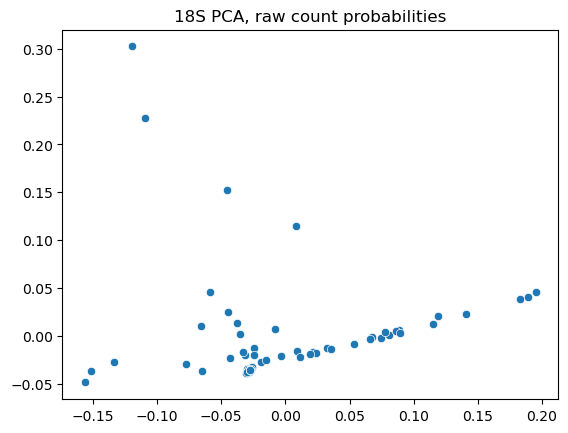

In [122]:
pca = PCA(n_components=3)
pcs = pca.fit_transform(df_18S)

pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values).set(title="18S PCA, raw count probabilities")

## 03. Test the power of 16S data as a predictor for 18S data

### Function to extract defined number of PCs with sample labels

In [123]:
def extract_PCs_labeled(df_asvs_modeled, num_pcs):
    pca = PCA(n_components=num_pcs)
    pcs = pca.fit_transform(df_asvs_modeled)
    array = pcs[:, :num_pcs]
    cols = list()
    for i in range(1, num_pcs+1):
        n="PC%s" % i
        cols.append(n)
    df = pd.DataFrame(array, index=df_16S.index, columns = cols)
    return(df)

#### Export the first six PCs of the 16S data which explain 97% of the variance

In [124]:
pcs_16S = extract_PCs_labeled(df_16S, 6)
#pcs_16S.to_csv("Flyer2018_16S_PCs.tsv", sep="\t")
#pcs_16S

#### Export the first two PCs of the 18S data for which we will test the 16S predictive power

In [125]:
pcs_18S = extract_PCs_labeled(df_18S, 2)
#pcs_18S.to_csv("Flyer2018_18S_PCs.tsv", sep="\t")
#pcs_18S

### Pass results of 16S and 18S PCAs to Bayesian modeling

#### Define variables based on PCA results from above; can only pass strings to R script

In [126]:
# Divide data into attributes and labels
df1 = pcs_16S[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
df1.columns = ['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16']
df2 = pcs_18S[['PC1', 'PC2'
              ]]
df2.columns = ['pc1_values_18',  
               'pc2_values_18'
              ]
df = pd.merge(df1, df2, left_index=True, right_index=True)
print(df1.shape, df2.shape, df.shape)

(62, 6) (62, 2) (62, 8)


In [127]:
df.head(3)

,pc1_values_16,pc2_values_16,pc3_values_16,pc4_values_16,pc5_values_16,pc6_values_16,pc1_values_18,pc2_values_18
CN18Fc12_8_eDNA,-0.020128,0.023832,-0.024139,0.038050,-0.016783,0.001938,-0.018686,-0.027522
CN18Fc19_5_eDNA,-0.075552,-0.033142,0.010200,-0.011909,0.003156,-0.002386,-0.133394,-0.027902
CN18Fc21_6_eDNA,-0.048505,-0.016760,-0.003077,0.003165,-0.006532,0.004679,-0.031460,-0.019696


### Create Bayesian Model

In [128]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [129]:
# Prepare training data
dataset_HA2 = df[['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16', 'pc1_values_18', 'pc2_values_18'
                         ]]
train = torch.tensor(dataset_HA2.values, dtype=torch.float)
pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18, pc2_values_18  = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6],  train[:, 7]


#### PC1_18

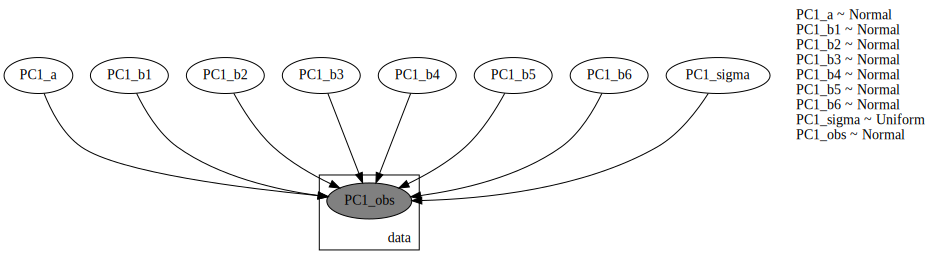

In [130]:
def model(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18):
    a = pyro.sample("PC1_a", dist.Normal(0., 10.))
    b_PC1 = pyro.sample("PC1_b1", dist.Normal(0., 1.))
    b_PC2 = pyro.sample("PC1_b2", dist.Normal(0., 1.))
    b_PC3 = pyro.sample("PC1_b3", dist.Normal(0., 1.))
    b_PC4 = pyro.sample("PC1_b4", dist.Normal(0., 1.))
    b_PC5 = pyro.sample("PC1_b5", dist.Normal(0., 1.))
    b_PC6 = pyro.sample("PC1_b6", dist.Normal(0., 1.))
    sigma = pyro.sample("PC1_sigma", dist.Uniform(0., 10.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with pyro.plate("data", len(pc6_values_16)):
        return pyro.sample("PC1_obs", dist.Normal(mean, sigma), obs=pc1_values_18)
pyro.render_model(model, model_args=(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18), render_distributions=True,  render_params=True)  

#### HMC - MCMC - NUTS

In [131]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|█| 1200/1200 [00:26, 44.89it/s, step size=7.46e-01, acc. prob=0.867


In [132]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: PC1_a
       mean       std        5%       25%       50%       75%       95%
0 -0.000205  0.009318 -0.015725 -0.006356 -0.000359  0.005889  0.015684 

Site: PC1_b1
       mean       std        5%       25%       50%       75%       95%
0 -0.248745  0.109922 -0.429034 -0.325337 -0.246535 -0.174081 -0.073942 

Site: PC1_b2
       mean       std        5%       25%       50%      75%       95%
0 -0.229392  0.153825 -0.489431 -0.330286 -0.226862 -0.12783  0.018289 

Site: PC1_b3
       mean      std        5%       25%       50%       75%      95%
0  0.299227  0.49975 -0.521493 -0.011954  0.299019  0.613403  1.10457 

Site: PC1_b4
       mean       std        5%       25%       50%       75%      95%
0 -0.576708  0.507491 -1.364032 -0.925085 -0.593239 -0.257425  0.26836 

Site: PC1_b5
       mean       std        5%       25%       50%       75%       95%
0  0.492166  0.642485 -0.547558  0.047986  0.479813  0.952155  1.530785 

Site: PC1_b6
       mean       std        5%       25% 

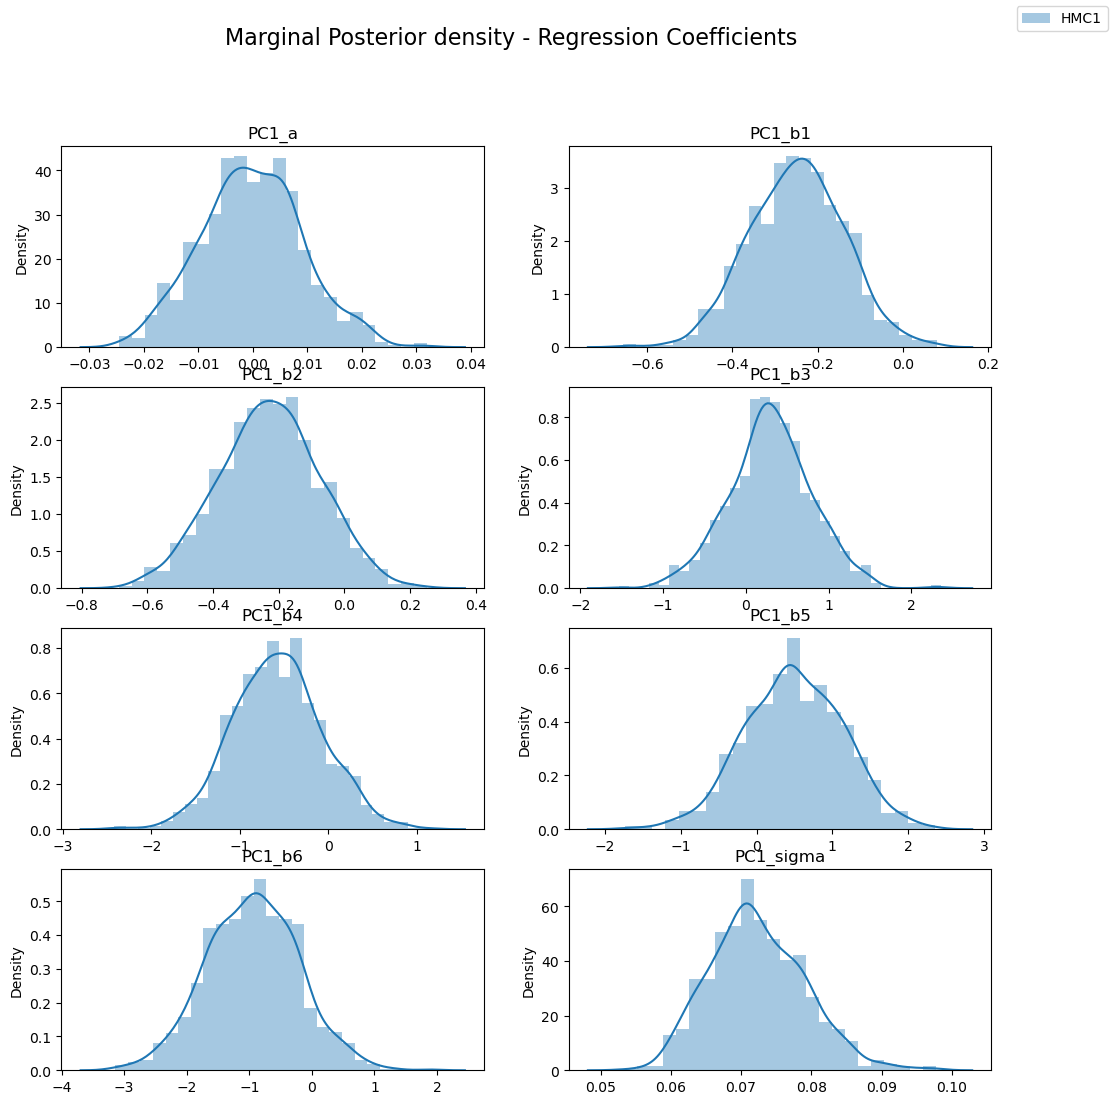

In [133]:
sites = ["PC1_a", "PC1_b1", "PC1_b2", "PC1_b3", "PC1_b4", "PC1_b5", "PC1_b6","PC1_sigma"]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(hmc_samples[site], ax=ax, label="HMC1")
    #sns.distplot(hmc_samples[site], ax=ax, label="HMC2")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

#### PC2_18

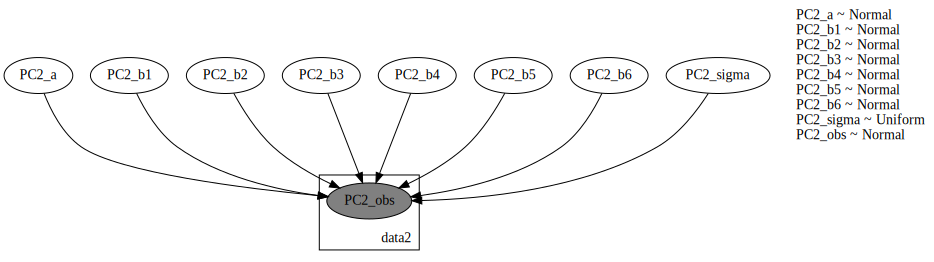

In [134]:
def model2(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc2_values_18):
    a = pyro.sample("PC2_a", dist.Normal(0., 10.))
    b_PC1 = pyro.sample("PC2_b1", dist.Normal(0., 1.))
    b_PC2 = pyro.sample("PC2_b2", dist.Normal(0., 1.))
    b_PC3 = pyro.sample("PC2_b3", dist.Normal(0., 1.))
    b_PC4 = pyro.sample("PC2_b4", dist.Normal(0., 1.))
    b_PC5 = pyro.sample("PC2_b5", dist.Normal(0., 1.))
    b_PC6 = pyro.sample("PC2_b6", dist.Normal(0., 1.))
    sigma = pyro.sample("PC2_sigma", dist.Uniform(0., 10.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with pyro.plate("data2", len(pc6_values_16)):
        return pyro.sample("PC2_obs", dist.Normal(mean, sigma), obs=pc2_values_18)
pyro.render_model(model2, model_args=(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc2_values_18), render_distributions=True,  render_params=True) 

In [135]:
from pyro.infer import MCMC, NUTS


nuts_kernel2 = NUTS(model2)

mcmc2 = MCMC(nuts_kernel2, num_samples=1000, warmup_steps=200)
mcmc2.run(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc2_values_18)

hmc_samples2 = {k: v.detach().cpu().numpy() for k, v in mcmc2.get_samples().items()}

Sample: 100%|█| 1200/1200 [00:29, 40.44it/s, step size=5.91e-01, acc. prob=0.922


In [136]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats
for site, values in summary(hmc_samples2).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: PC2_a
       mean       std       5%       25%     50%       75%       95%
0  0.000392  0.007063 -0.01086 -0.004221  0.0004  0.004835  0.012316 

Site: PC2_b1
       mean       std        5%       25%       50%       75%       95%
0 -0.290154  0.087975 -0.429425 -0.354441 -0.288571 -0.226553 -0.147883 

Site: PC2_b2
       mean       std       5%       25%       50%       75%       95%
0 -0.094246  0.124667 -0.30156 -0.175187 -0.092938 -0.011504  0.107288 

Site: PC2_b3
       mean       std       5%       25%       50%       75%      95%
0  0.697162  0.388966  0.09061  0.415406  0.686037  0.960364  1.34582 

Site: PC2_b4
      mean       std        5%       25%       50%       75%       95%
0 -0.22843  0.433979 -0.944676 -0.526683 -0.224699  0.068416  0.466084 

Site: PC2_b5
       mean       std        5%       25%       50%       75%       95%
0 -0.138113  0.536224 -1.060057 -0.495913 -0.144914  0.239405  0.745092 

Site: PC2_b6
       mean       std        5%       25%       

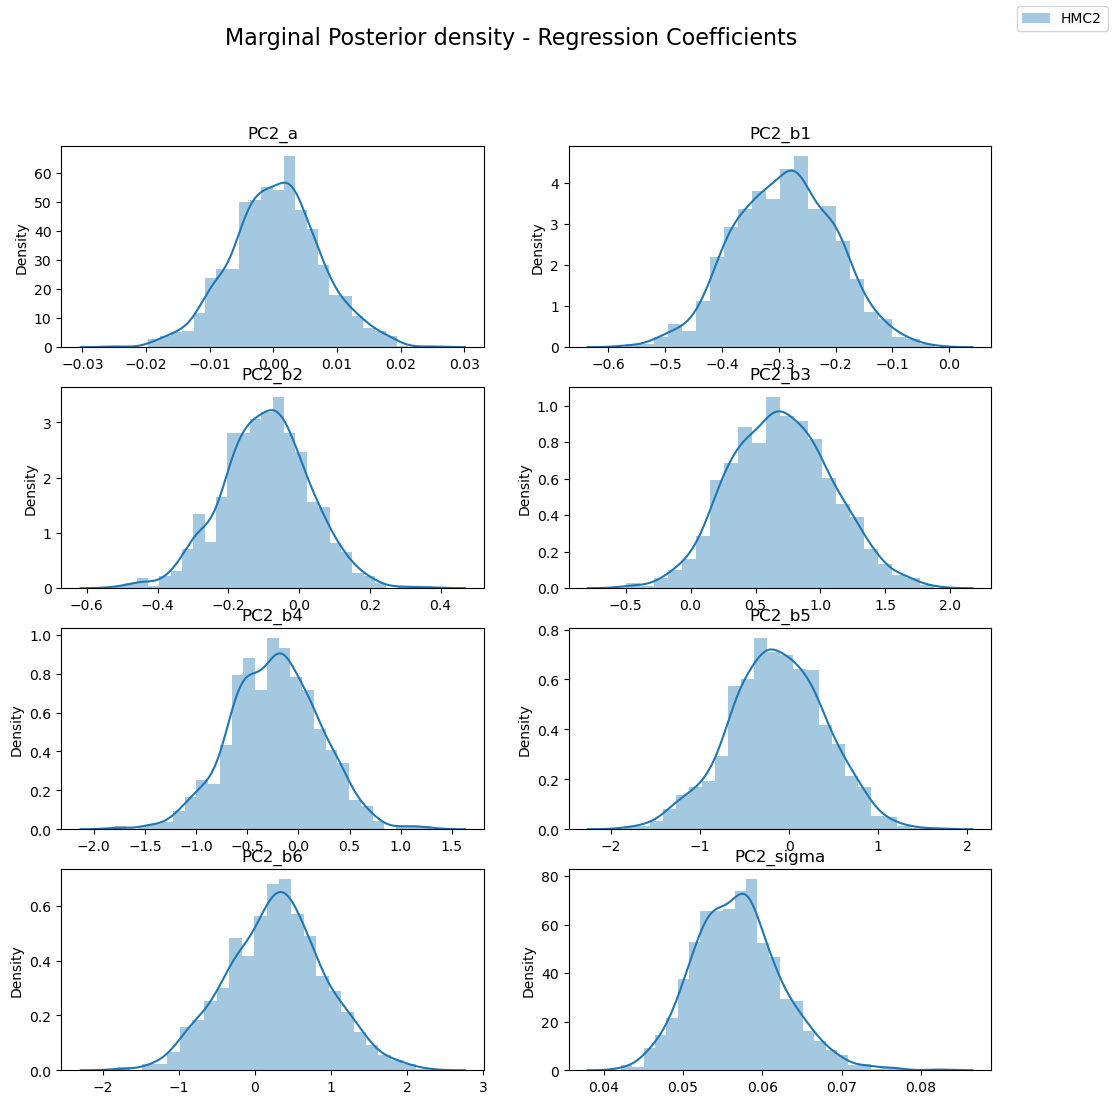

In [137]:
sites = ["PC2_a", "PC2_b1", "PC2_b2", "PC2_b3", "PC2_b4", "PC2_b5", "PC2_b6","PC2_sigma"]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    #sns.distplot(hmc_samples1[site], ax=ax, label="HMC1)")
    sns.distplot(hmc_samples2[site], ax=ax, label="HMC2")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');